<a href="https://colab.research.google.com/github/RahulNaugariya/twitter_sentiment_analysiss/blob/main/Twitter_Sentiment_Analysis_using_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [72]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#configure the path of kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d kazanova/sentiment140

 90% 73.0M/80.9M [00:00<00:00, 202MB/s]
100% 80.9M/80.9M [00:00<00:00, 188MB/s]


In [4]:
from zipfile import ZipFile
dataset = '/content/sentiment140.zip'

with ZipFile(dataset, 'r') as zip:
  zip.extractall()
  print("The dataset has been successfully extracted")

The dataset has been successfully extracted


In [5]:
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

In [6]:
data = pd.read_csv('/content/training.1600000.processed.noemoticon.csv', encoding = 'ISO-8859-1')

In [7]:
sampled_df = data.sample(n=500000, random_state=42)

In [8]:
sampled_df.to_csv('sampled_dataset.csv', index=False)

In [9]:
sampled_df.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
541200,0,2200003313,Tue Jun 16 18:18:13 PDT 2009,NO_QUERY,DEWGetMeTho77,@Nkluvr4eva My poor little dumpling In Holmde...
750,0,1467998601,Mon Apr 06 23:11:18 PDT 2009,NO_QUERY,Young_J,I'm off too bed. I gotta wake up hella early t...
766711,0,2300049112,Tue Jun 23 13:40:12 PDT 2009,NO_QUERY,dougnawoschik,I havent been able to listen to it yet My spe...
285055,0,1993474319,Mon Jun 01 10:26:09 PDT 2009,NO_QUERY,thireven,now remembers why solving a relatively big equ...
705995,0,2256551006,Sat Jun 20 12:56:51 PDT 2009,NO_QUERY,taracollins086,"Ate too much, feel sick"


In [10]:
def random_colours(number_of_colors):
    '''
    Simple function for random colours generation.
    Input:
        number_of_colors - integer value indicating the number of colours which are going to be generated.
    Output:
        Color in the following format: ['#E86DA4'] .
    '''
    colors = []
    for i in range(number_of_colors):
        colors.append("#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]))
    return colors

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

In [12]:
data.shape

(1599999, 6)

In [13]:
sampled_df.shape

(500000, 6)

In [14]:
column_names = ['target', 'id', 'data', 'flag', 'user', 'text']
sampled_df = pd.read_csv('/content/sampled_dataset.csv', names = column_names ,encoding = 'ISO-8859-1')

In [15]:
sampled_df.head()

,target,id,data,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,2200003313,Tue Jun 16 18:18:13 PDT 2009,NO_QUERY,DEWGetMeTho77,@Nkluvr4eva My poor little dumpling In Holmde...
2,0,1467998601,Mon Apr 06 23:11:18 PDT 2009,NO_QUERY,Young_J,I'm off too bed. I gotta wake up hella early t...
3,0,2300049112,Tue Jun 23 13:40:12 PDT 2009,NO_QUERY,dougnawoschik,I havent been able to listen to it yet My spe...
4,0,1993474319,Mon Jun 01 10:26:09 PDT 2009,NO_QUERY,thireven,now remembers why solving a relatively big equ...


In [16]:
sampled_df.shape

(500001, 6)

In [17]:
sampled_df.replace({'target':{4:1}}, inplace=True )

In [18]:
sampled_df.isnull().sum()

target    0
id        0
data      0
flag      0
user      0
text      0
dtype: int64

In [19]:
temp = sampled_df.groupby('target').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp.style.background_gradient(cmap='Purples')

,target,text
1,1,250625
0,0,249376


<Axes: xlabel='target', ylabel='count'>

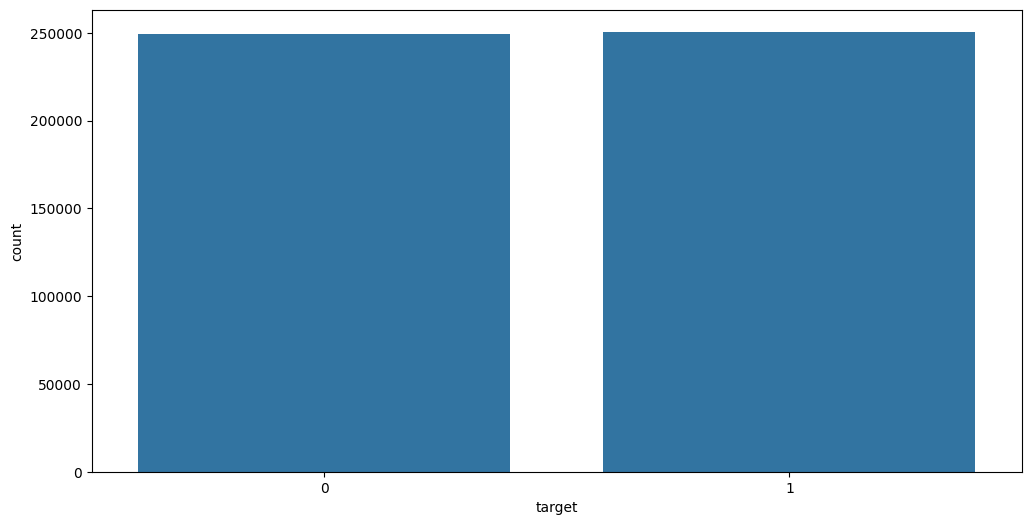

In [20]:
plt.figure(figsize=(12,6))
sns.countplot(x='target',data=sampled_df)

In [21]:
sampled_df['target'].value_counts()

target
1    250625
0    249376
Name: count, dtype: int64

In [22]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [23]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [24]:
port_stem = PorterStemmer()

In [25]:
def stemming(content):
  stemmed_content = re.sub('[^a-zA-Z]', ' ', content)
  stemmed_content = stemmed_content.lower()
  stemmed_content = stemmed_content.split()
  stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
  stemmed_content = ' '.join(stemmed_content)

  return stemmed_content

In [26]:
sampled_df['stemmed_content'] = sampled_df['text'].apply(stemming)

In [27]:
 sampled_df.head()

,target,id,data,flag,user,text,stemmed_content
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot http twitpic com zl awww bummer sho...
1,0,2200003313,Tue Jun 16 18:18:13 PDT 2009,NO_QUERY,DEWGetMeTho77,@Nkluvr4eva My poor little dumpling In Holmde...,nkluvr eva poor littl dumpl holmdel vid realli...
2,0,1467998601,Mon Apr 06 23:11:18 PDT 2009,NO_QUERY,Young_J,I'm off too bed. I gotta wake up hella early t...,bed gotta wake hella earli tomorrow morn
3,0,2300049112,Tue Jun 23 13:40:12 PDT 2009,NO_QUERY,dougnawoschik,I havent been able to listen to it yet My spe...,havent abl listen yet speaker bust
4,0,1993474319,Mon Jun 01 10:26:09 PDT 2009,NO_QUERY,thireven,now remembers why solving a relatively big equ...,rememb solv rel big equat two unknown total pa...


In [28]:
print(sampled_df['stemmed_content'])

0         switchfoot http twitpic com zl awww bummer sho...
1         nkluvr eva poor littl dumpl holmdel vid realli...
2                  bed gotta wake hella earli tomorrow morn
3                        havent abl listen yet speaker bust
4         rememb solv rel big equat two unknown total pa...
                                ...                        
499996                                     go katuti pamper
499997                                      need chap stick
499998                                  hazeymari want wait
499999    bookcrossingfan wow wonder odd happen finger c...
500000                                   want orang chicken
Name: stemmed_content, Length: 500001, dtype: object


In [29]:
X = sampled_df['stemmed_content'].values
y = sampled_df['target'].values

In [30]:
print(X)

['switchfoot http twitpic com zl awww bummer shoulda got david carr third day'
 'nkluvr eva poor littl dumpl holmdel vid realli tri hope dont tri hard tonight xx'
 'bed gotta wake hella earli tomorrow morn' ... 'hazeymari want wait'
 'bookcrossingfan wow wonder odd happen finger cross journal entri time'
 'want orang chicken']


In [31]:
print(y)

[0 0 0 ... 0 1 0]


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state= 2)

In [33]:
print(X_train)

['iamajeaniu feel realli crap jean unless stop throw everi second wont'
 'realli bore ill pollut blood like toxic come gone one like cannot avoid'
 'jswching take pic' ... 'soup sunday yummi'
 'therealmrriley cool bub x sigh tri hard smile kmt lol erm thought cum vampir stat aint ya tire'
 'magic panti thought pretti cool']


In [34]:
print(y_train)

[0 0 1 ... 1 1 1]


In [35]:
print(X_test)

['spauld busi tri advertis chariti event well thank' 'meh coach yet'
 'napp news eheh funni way promot nice articl actual find drawback sure signup today'
 ...
 'cb heey good hear work saturday though happi keep compani via twitter'
 'cheektv pictur http twitpic com zfhi video http bit ly yamqm twitter whore way made difficult find xd'
 'take anymor done noth wat get n dont even tell truth n reason']


In [36]:
vectorizer = TfidfVectorizer()

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [37]:
print(X_train)

  (0, 203225)	0.2702140598388064
  (0, 163095)	0.27699727075930713
  (0, 56996)	0.25527539804767774
  (0, 185903)	0.3089857650224841
  (0, 175590)	0.23936766219160466
  (0, 194268)	0.3228820703826764
  (0, 87938)	0.338467289872772
  (0, 38401)	0.27462967537268557
  (0, 152450)	0.17954185914567528
  (0, 59562)	0.17740529474370687
  (0, 79501)	0.5238128962205919
  (1, 12967)	0.3328017281332725
  (1, 27521)	0.28507070077732666
  (1, 137203)	0.1684472831531989
  (1, 69063)	0.24090968159418272
  (1, 36124)	0.18277627437850044
  (1, 188975)	0.42667495444443587
  (1, 106664)	0.30810601581026675
  (1, 20621)	0.301402211195225
  (1, 145741)	0.42447108278113993
  (1, 81263)	0.24879599314596504
  (1, 22066)	0.21862908259162442
  (1, 152450)	0.17452973450646556
  (2, 143697)	0.3921211957877284
  (2, 179697)	0.33620267069785675
  :	:
  (399997, 171945)	0.6473873363611925
  (399997, 177228)	0.4851590493458748
  (399997, 208735)	0.5878012704621922
  (399998, 100220)	0.36527042496550705
  (399998, 184

In [38]:
print(X_test)

  (0, 200336)	0.20715047436680284
  (0, 189815)	0.22553750749703005
  (0, 182778)	0.19160171935223858
  (0, 172369)	0.558966039842895
  (0, 56950)	0.3438193328952544
  (0, 30684)	0.43441891096181423
  (0, 25801)	0.2808199054039812
  (0, 2255)	0.41385494799550904
  (1, 207538)	0.4193435540939068
  (1, 118192)	0.6331403144693766
  (1, 35326)	0.6506030478206427
  (2, 199571)	0.1640625585438358
  (2, 187678)	0.1324060841684881
  (2, 177929)	0.17916628415741562
  (2, 167411)	0.36264782282652624
  (2, 147900)	0.27805390533393815
  (2, 131637)	0.16504835772864807
  (2, 131208)	0.21166569109901068
  (2, 129231)	0.37977245062245235
  (2, 64447)	0.2018192809994822
  (2, 60514)	0.17851554322454496
  (2, 52912)	0.3846700204822611
  (2, 49723)	0.4195743779500702
  (2, 10896)	0.25530130044500154
  (2, 1495)	0.19121305557993762
  :	:
  (99999, 201622)	0.337754142776977
  (99999, 199571)	0.18884315093456522
  (99999, 196994)	0.22744847643261967
  (99999, 192030)	0.1765534289123999
  (99999, 191965)	0.

***Training the machine learning models***

**Logistic Regression**

In [39]:
logistic_model = LogisticRegression(max_iter = 1000)

In [40]:
logistic_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

Model Evaluation

Accuracy score and classification report

In [41]:
#accuracy score on the training data
X_train_prediction = logistic_model.predict(X_train)
training_data_accuracy = accuracy_score(y_train, X_train_prediction)

In [42]:
print("Accuracy score on the training data: ", training_data_accuracy)

Accuracy score on the training data:  0.814565


In [64]:
#accuracy score on the testing data
X_test_prediction = logistic_model.predict(X_test)
logistic_test_data_accuracy = accuracy_score(y_test, X_test_prediction)

In [65]:
print("Accuracy score on the testing data: ", logistic_test_data_accuracy)

Accuracy score on the testing data:  0.7702122978770213


In [45]:
from sklearn.metrics import classification_report

In [46]:
y_pred = logistic_model.predict(X_test)

In [58]:
print("Classification Report:")
logistic_report = classification_report(y_test, y_pred)
print(logistic_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.78      0.75     49876
           1       0.76      0.72      0.74     50125

    accuracy                           0.75    100001
   macro avg       0.75      0.75      0.75    100001
weighted avg       0.75      0.75      0.75    100001



In [48]:
import pickle
with open('logistic_model.pkl', 'wb') as f:
    pickle.dump(logistic_model, f)

**Naive Bayes**

In [49]:
from sklearn.model_selection import train_test_split, GridSearchCV

In [50]:
naive_bayes_model = MultinomialNB()
naive_bayes_model.fit(X_train, y_train)

MultinomialNB()

In [51]:
param_grid = {'alpha': [0.1, 0.5, 1.0]}  # Adjust alpha values as needed
grid_search = GridSearchCV(naive_bayes_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.1, 0.5, 1.0]}, scoring='accuracy')

In [52]:
# Best hyperparameters
best_alpha = grid_search.best_params_['alpha']

In [53]:
# Train the Naive Bayes classifier with the best hyperparameters
best_naive_bayes = MultinomialNB(alpha=best_alpha)
best_naive_bayes.fit(X_train, y_train)

MultinomialNB()

In [59]:
y_pred = best_naive_bayes.predict(X_test)
naive_bayes_report = classification_report(y_test, y_pred)
print(naive_bayes_report)

              precision    recall  f1-score   support

           0       0.73      0.78      0.75     49876
           1       0.76      0.72      0.74     50125

    accuracy                           0.75    100001
   macro avg       0.75      0.75      0.75    100001
weighted avg       0.75      0.75      0.75    100001



In [55]:
print("Accuracy score on the training data: ", training_data_accuracy)

Accuracy score on the training data:  0.814565


In [66]:
# Evaluate the model on the test set
y_pred = best_naive_bayes.predict(X_test)

# Calculate the accuracy score
naive_test_data_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", naive_test_data_accuracy)

Accuracy: 0.7473125268747313


In [57]:
with open('naive_bayes_model.pkl', 'wb') as f:
    pickle.dump(naive_bayes_model, f)

Random Forest

In [68]:
from sklearn.ensemble import RandomForestClassifier

In [69]:
# Initialize Random Forest classifier
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)